In [1]:
import csv
import math
import pickle
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
import pingouin as pg
from sklearn.metrics import mutual_info_score
warnings.filterwarnings('ignore')


# **ICC, Bland-Altmann and LMM Analysis**

In [2]:
def save_dict_list_as(dic, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(dic, file)
    return 0
    

def load_dict_list(file_name):
    with open(file_name, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

def scientific_notation(value):
    if abs(value) < 1 and value != 0:
        return '{:.2e}'.format(value)
    else:
        return '{:.2f}'.format(float(value))

In [3]:
full_weeks = pd.read_csv('data_set/data_for_analysis.csv') # load prep data for analysis

#covid = pd.read_csv('data_set/data_covid_for_analysis.csv')

features = load_dict_list('Food_group/features.pkl')

### **LMM analysis**

In [19]:

def compute_LMM(data, features = features, save = False, covid = False):
    p_values = pd.DataFrame(index=features, columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]) 
    coef_values = pd.DataFrame(index=features, columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

    for f in tqdm(features) : 
        subject = pd.DataFrame()
        subject["subject_key"] = data["subject_key"]
        modele_comp = smf.mixedlm(f"{f} ~ C(week_day, Treatment(reference='Monday')) + C(gender) + C(bmi_cat) + C(age_group)", data, groups=data["subject_key"])
        result = modele_comp.fit()
        coef_values.at[f, "Monday"] = result.params['Intercept']
        p_values.at[f, "Monday"] = 0
        for day in ["Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:  
            p_value = result.pvalues[f'C(week_day, Treatment(reference=\'Monday\'))[T.{day}]']
            p_values.at[f, day] = p_value
            coef_values.at[f, day] = result.params[f'C(week_day, Treatment(reference=\'Monday\'))[T.{day}]']
    text = ""
    if covid:
        text = "_covid"
    if save :      
        p_values.to_csv(f'data_set/LMM/p_values{text}.csv')
        coef_values.to_csv(f'data_set/LMM/coef_values{text}.csv')
    return p_values, coef_values


In [20]:
def plot_LMM_heatmap(p_values, coef_values):

    week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    p_val = pd.DataFrame(p_values.values.copy(), index=features, columns=week)
    coef = pd.DataFrame(coef_values.values.copy(), index=features, columns=week)

        
    coef = coef.applymap(scientific_notation)

    for i in features:
        p_val.rename(index={i: '{} ({})'.format(i, coef["Monday"][i])}, inplace=True)
        
    p_values_float = p_val.astype(float)
    annotations = coef
    values_monday = annotations['Monday']
    for day in annotations.columns:
        if day != 'Monday':
            annotations[day] = annotations[day]
            


    p_val = p_values_float.drop(columns="Monday")
    annotations.drop(columns="Monday", inplace=True)
    bounds = [0, 0.001, 0.01, 0.05, 1]
    colors = ["#ffad99", "#fc8d59", "#ffffbf", "#fff79d","#ebebeb"]

    custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(p_val, annot=annotations, cmap=custom_cmap, norm=norm, cbar=True,
                    linewidths=0.5, linecolor='black', fmt="s")
    plt.title('Coefficients values and P-values [color] by Day of the Week Compared to Monday')
    plt.ylabel('Feature (Global Monday Intercept [g])')
    plt.xlabel('Day of the Week')
    plt.yticks(rotation=0)  
    plt.hlines(y=p_val.shape[0], xmin=0, xmax=p_val.shape[1], color='black', linewidth=2)
    plt.vlines(x=p_val.shape[1], ymin=0, ymax=p_val.shape[0], color='black', linewidth=2)
    plt.tight_layout()      
    cbar = ax.collections[0].colorbar
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(0.5)

    plt.show()


100%|██████████| 37/37 [02:10<00:00,  3.54s/it]


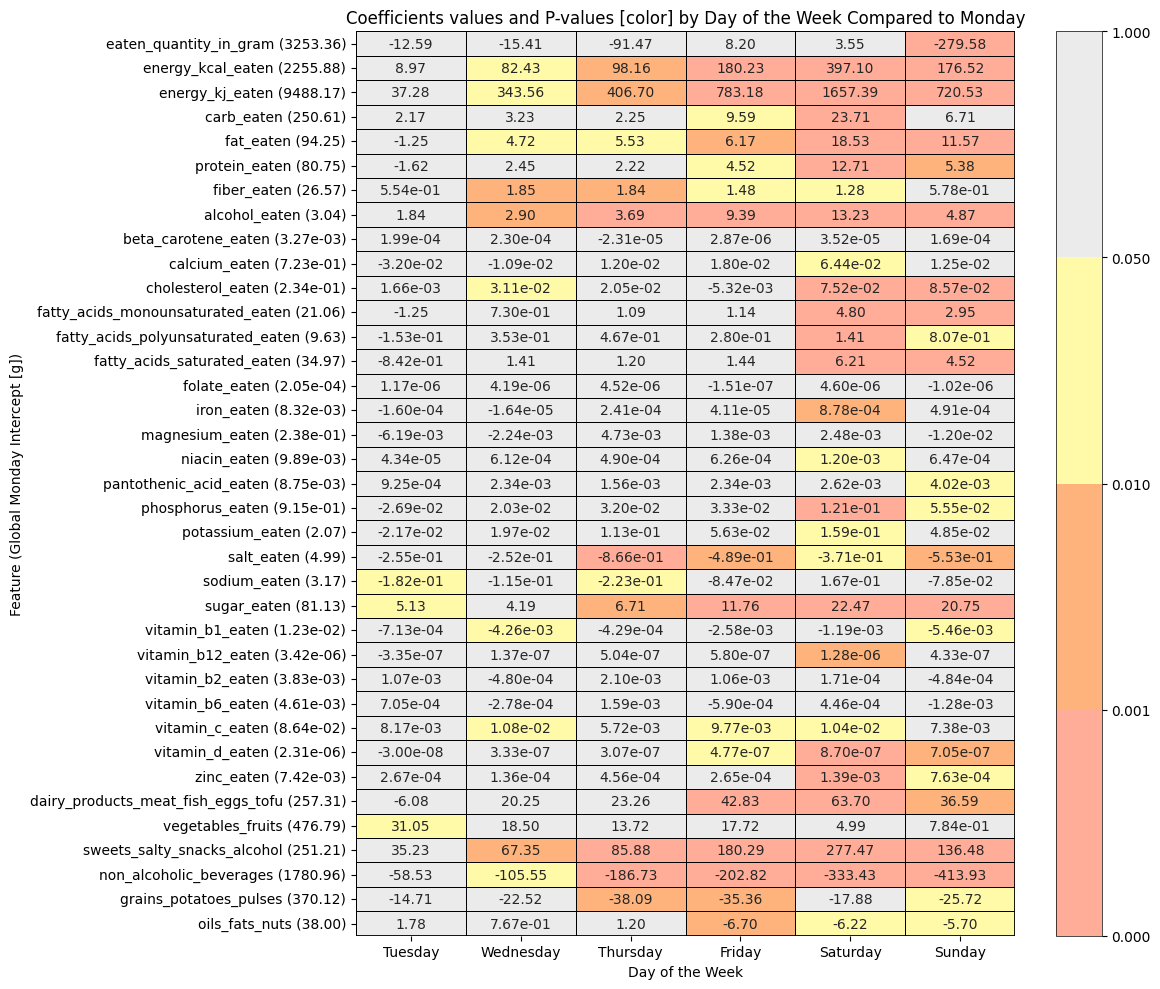

In [21]:
stat = compute_LMM(full_weeks, save = True)
plot_LMM_heatmap(stat[0], stat[1])

### **ICC Analysis**

**functions to compute and plot ICC using the mean for the consecutive days combination (Mon --> Mon-Tue --> ... --> Mon to Sun) approach**

In [4]:

criterion_mean = full_weeks[["subject_key"] +features]
criterion_mean = criterion_mean.groupby(['subject_key']).mean().reset_index()
criterion_mean["judge"] = "A"

# crit_covid = covid[["subject_key"] +features]
# crit_covid_mean = crit_covid.groupby(['subject_key']).mean().reset_index()
# crit_covid_mean["judge"] = "A"

def ICC_mean_consec(data = full_weeks, features = features, criterion = criterion_mean, single_day = False):
    week =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    icc_scores = {}
    current_day=[]
    
    for i,d in enumerate(tqdm(week)): 
        if not single_day:
            current_day.append(d)
        else : 
            current_day = [d]
        day = data.copy()
        day =day[day['week_day'].isin(current_day)]
        day = day[["subject_key"] + features]
        day= day.groupby('subject_key')[features].mean()
        day.reset_index(inplace=True) 
        day["judge"] = "B"
        matrix = pd.concat([criterion, day], axis=0)
        matrix.reset_index(drop=True, inplace=True) 

        stock = []
        
        for c in features :
            results = pg.intraclass_corr(data= matrix, targets='subject_key', raters='judge', ratings=c)
            score = results.loc[results['Type'] == 'ICC3']["ICC"].values[0]  # ==> 2 way mixed model ICC
            stock.append(score)
        
        if not single_day:
            icc_scores[len(current_day)] = stock
        else:
            icc_scores[f"{d}"] = stock
            
    return icc_scores  # {1 : [icc_feat_1,....,iccfeat_n],....., N : [icc_feat_1,....,icc_feat_n}

In [5]:

# {1 : [icc_feat_1,....,iccfeat_n],....., N : [icc_feat_1,....,icc_feat_n}

def plot_ICC(icc_scores, features = features, nb_day = 7, add_curve_uncons = False, var = False):
    
    num_features = len(features)
    num_rows = int(math.ceil(math.sqrt(num_features)))
    num_cols = int(math.ceil(num_features / num_rows))
    fig_width = num_cols * 4
    fig_height = num_rows * 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    max_value = float('-inf')
    min_value = float('inf')
    axs = axs.ravel() 
    
    for i, c in enumerate(features):
        start = 1
        if var:
            start = 2
        icc_values = [icc_scores[j][i] for j in range(start,nb_day+1)]
        max_value = max(max_value, max(icc_values))
        min_value = min(min_value, min(icc_values))
        label = [None,None]
        if i == 0 :
            label = [ "ICC consecutive days (Mon --> Sun)", "Avg ICC non consecutive days"]
        axs[i].plot(range(start, nb_day + 1), icc_values, marker='s', label = label[0])
        if add_curve_uncons:
            axs[i].plot(range(2, nb_day+1), icc_values, marker='s', color="red", label=label[1])  
        axs[i].set_title(c.replace('_', ' ').replace('eaten', ''))
        axs[i].axhline(y=0.8, linestyle='--', linewidth=0.8)
        axs[i].axhspan(0.6, 0.8, facecolor='orange', alpha=0.5)
        axs[i].axhspan(0.8, 1, facecolor='green', alpha=0.5)
        axs[i].axhline(y=0.6, linestyle='--', linewidth=0.8, color = "orange")
        axs[i].set_xticks(range(start, nb_day + 1))

    for i in range(num_features, num_rows * num_cols):
        axs[i].axis('off')
    for ax in axs[:num_features]:
        ax.set_ylim(min_value, max_value)

    fig.legend(loc='lower right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)
    plt.tight_layout()
    plt.show()




In [6]:
# PLOT SINGLE WEEK DAY ICC
def plot_single_day_ICC(icc_score_single_day):
    numb08 = {}
    numb06 = {}
    mean_icc_single_day = {}
    for day, icc in icc_score_single_day.items():
        val = icc_score_single_day[day] 
        val08= sum(1 for x in val if x >= 0.8)
        val06= sum(1 for x in val if x >= 0.6)
        numb08[day] = val08
        numb06[day] = val06
        mean_icc = sum(icc) / len(icc)
        mean_icc_single_day[day] = mean_icc
    scores = list(mean_icc_single_day.values())
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days =[f"{i} \n" + f"ICC>0.6: {numb06[i]}\n" + f"ICC>0.8: {numb08[i]}" for i in days]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x=days, height=scores)
    plt.ylabel('ICC Score')
    plt.axhspan(0.6, 0.8, facecolor='orange', alpha=0.5)

    plt.axhspan(0.8, 1, facecolor='green', alpha=0.5)
    plt.ylim(0, 1)
    plt.axhline(y=0.8, linestyle='--', linewidth=0.8, color = "green")
    plt.axhline(y=0.6, linestyle='--', linewidth=0.8, color = "orange")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.show()  

In [26]:
# icc_covid_single_day = ICC_mean_consec(data = covid, single_day=True, criterion= crit_covid_mean)
# icc_covid_consec = ICC_mean_consec(data = covid, criterion= crit_covid_mean)
# plot_ICC(icc_covid_consec)
# plot_single_day_ICC(icc_covid_single_day)


In [7]:
icc_mean_single_day = ICC_mean_consec(single_day=True)
icc_mean_consec = ICC_mean_consec()
save_dict_list_as(icc_mean_single_day, "ICC_Results\consecutive\mean\icc_mean_single_day.pkl")
save_dict_list_as(icc_mean_consec, "ICC_Results\consecutive\mean\icc_mean_consec.pkl")


100%|██████████| 7/7 [01:12<00:00, 10.32s/it]


0

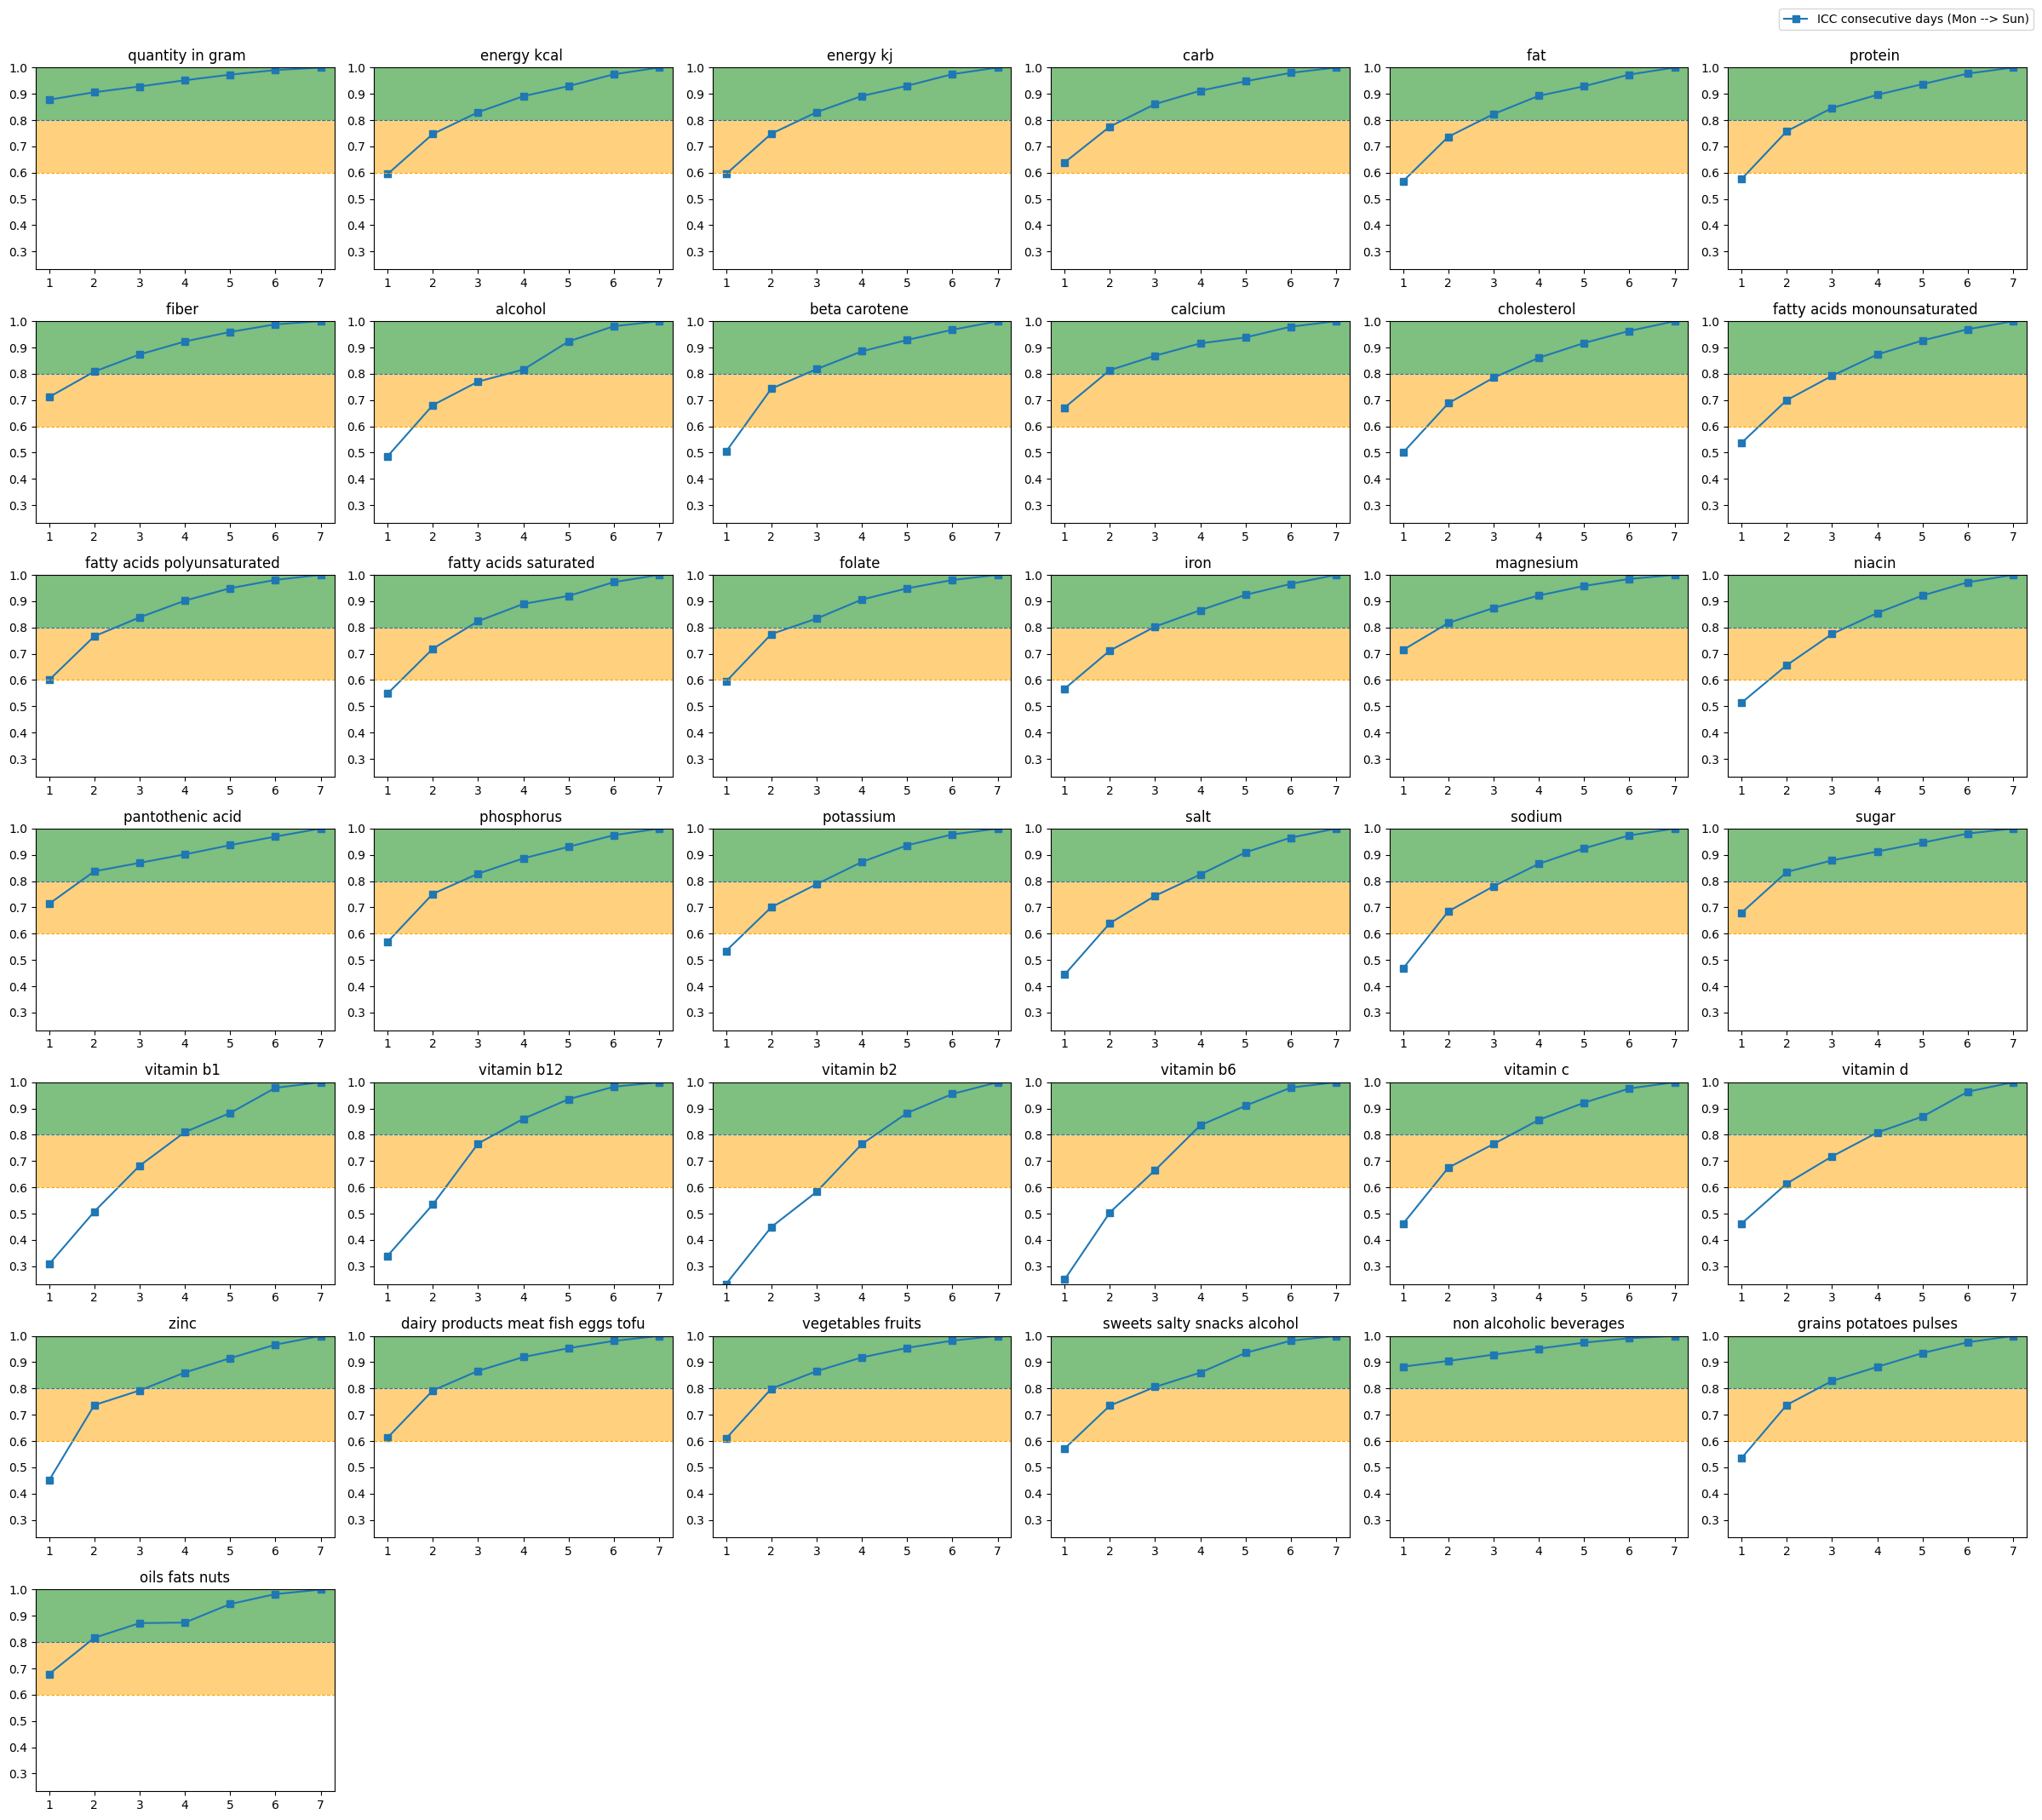

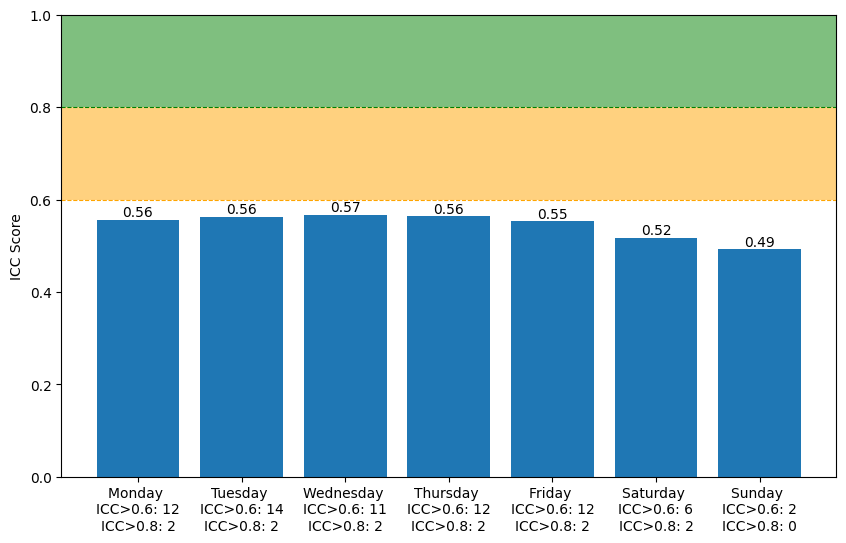

In [8]:
plot_ICC(icc_mean_consec)
plot_single_day_ICC(icc_mean_single_day)

 **functions to compute and plot ICC using the W-std for the consecutive days combination (Mon --> Mon-Tue --> ... --> Mon to Sun) approach**

In [10]:
# Compute W-std using LMM

# {feature_1 :{2: Dataframe(var,...,var),....., N: Dataframe(var,...,var},....,feature_N : {2: Dataframe(var,...,var,....., N: Dataframe(var,...,var]}}
def wstd_consec(data = full_weeks,features = features):
    wstd_week_consec = {f: {} for f in features}
    week=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    current_day=[]
    
    for i,d in enumerate(tqdm(week)): 
        current_day.append(d)
        day = data.copy()
        day =day[day['week_day'].isin(current_day)]
        if i > 0:
            for f in features : 
                subject = pd.DataFrame()
                subject["subject_key"] = full_weeks["subject_key"]
                modele_comp = smf.mixedlm(f"{f} ~ C(week_day, Treatment(reference='Monday')) + C(gender) + C(bmi_cat) + C(age_group)", day, groups=day["subject_key"])
                result = modele_comp.fit()
                subject["residual"] = result.resid
                var = subject.groupby('subject_key')['residual'].std()
                wstd_week_consec[f][len(current_day)] = var.reset_index(drop=True).to_list()
    return wstd_week_consec            

In [11]:
wstd_week_consec = wstd_consec()

100%|██████████| 7/7 [07:25<00:00, 63.71s/it]


In [12]:
def ICC_wstd_consec(wstd_values, nb_day = 7, features = features, data = full_weeks):
    icc_wstd_consec = {d : [] for d in range(2, nb_day+1)}
    for f in tqdm(features):
        criterion_wstd = pd.DataFrame(columns=["wstd", "subject_key", "judge"])
        criterion_wstd["wstd"] = wstd_values[f][nb_day]
        criterion_wstd["subject_key"] = full_weeks.groupby("subject_key").nunique().index
        criterion_wstd["judge"] = "A"
        for  d,list_wstd in wstd_values[f].items():
            day = pd.DataFrame(columns=["wstd", "subject_key", "judge"])
            day["wstd"]  = list_wstd
            day["subject_key"] = full_weeks.groupby("subject_key").nunique().index
            day["judge"] = "B"
            matrix = pd.concat([criterion_wstd, day], axis=0)
            icc = pg.intraclass_corr(data= matrix, targets='subject_key', raters="judge", ratings='wstd')
            icc_wstd_consec[d].append(icc.loc[icc['Type'] == 'ICC3']["ICC"].values[0]) # ==> 2 way mixed model ICC
    return icc_wstd_consec


In [13]:
wstd_week_consec = wstd_consec()
icc_wstd_consec = ICC_wstd_consec(wstd_values=wstd_week_consec)
save_dict_list_as(icc_wstd_consec,"ICC_Results\consecutive\w_std\icc_wstd_consec.pkl")

100%|██████████| 37/37 [01:08<00:00,  1.84s/it]


0

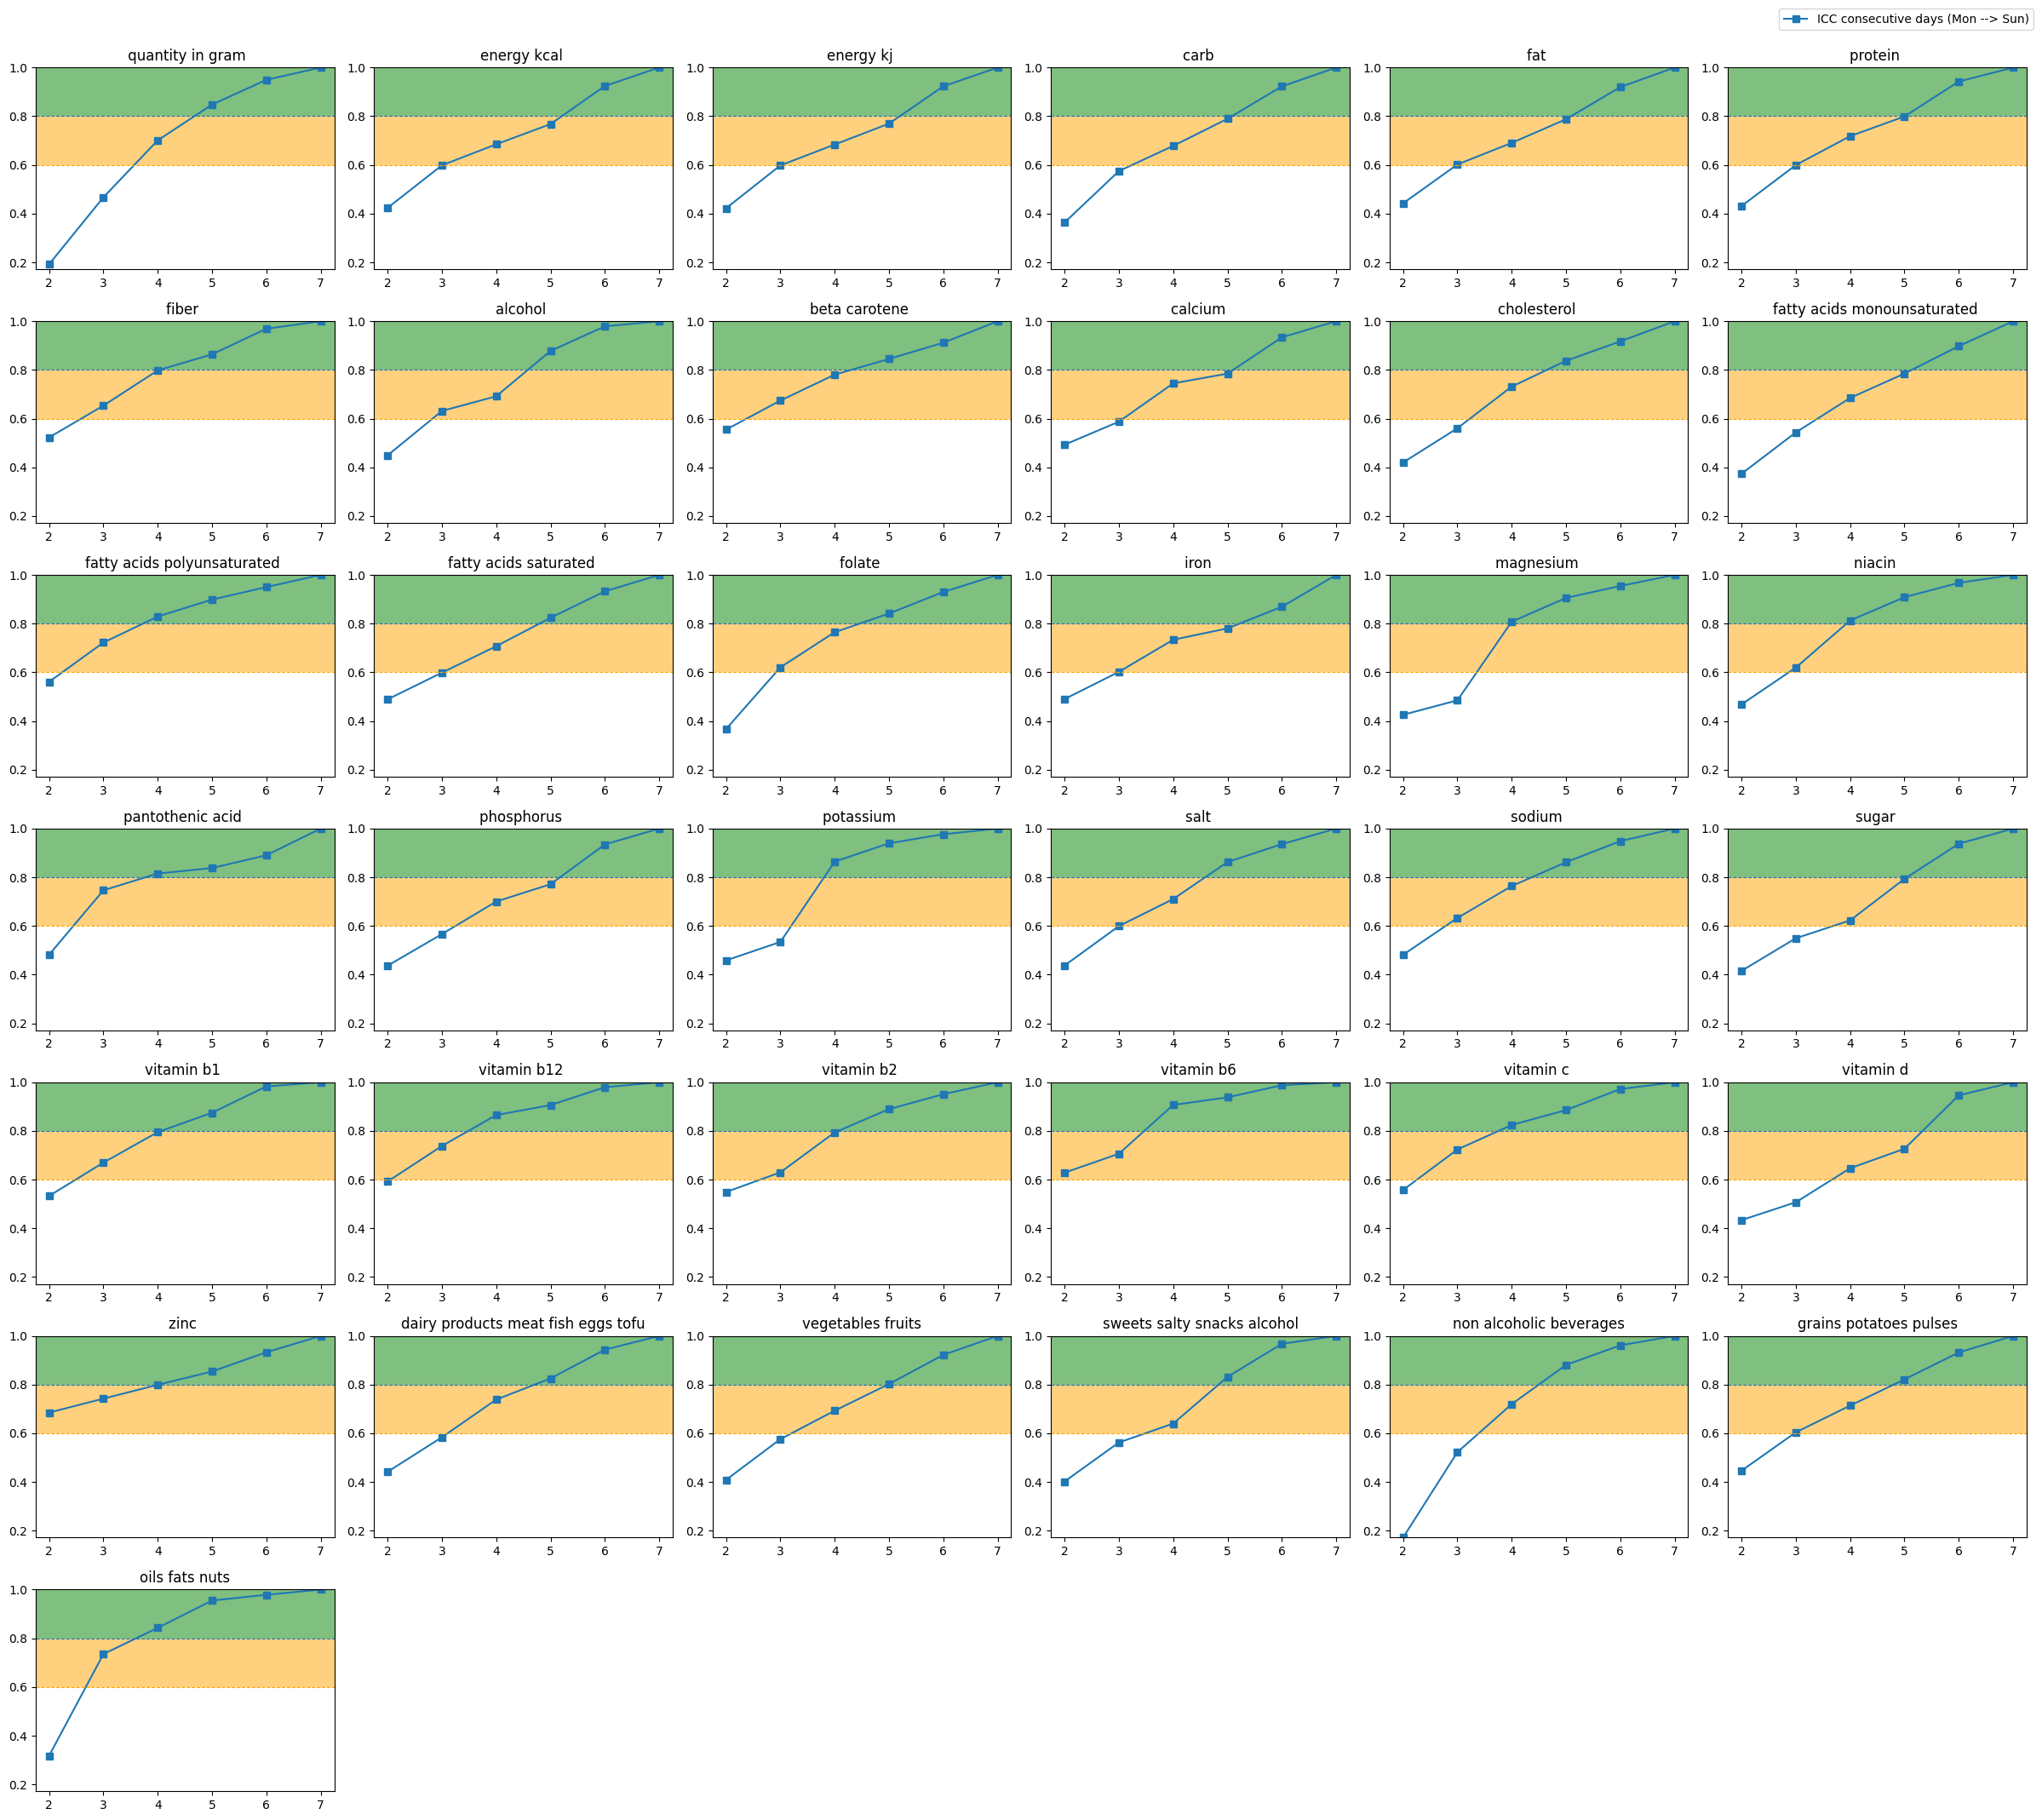

In [14]:
plot_ICC(icc_wstd_consec, var=True)

### **Non-consecutive days approach**

In [9]:
import itertools
import random


def convert_days(comb):
    days = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday"
}
    return tuple(days[x] for x in comb)


def all_combinations(nb_days, numb_comb=0):
    days = [i for i in range(1, nb_days + 1)]
    day_comb = {}
    # Generate all possible combinations for each size from 1 to nb_days
    for i in range(2, nb_days):
        # Generate all combinations of size i
        day_combinations = list(itertools.combinations(days, i))
        # Filter out the sequential combination if its length is greater than 1
        if i > 1:
            sequential_combination = tuple(range(1, i + 1))
            day_combinations = [comb for comb in day_combinations if comb != sequential_combination]
        day_comb[i] = day_combinations
    if numb_comb != 0 : 
        for key, item in day_comb.items():
            if len(item) > numb_comb:
                day_comb[key] = random.sample(item, numb_comb)
    day_comb[7] = [tuple(range(1, nb_days + 1))]
    return day_comb

def convert_day_comb(day_comb):
    for key, values in day_comb .items():
        day_comb[key] = [convert_days(comb) for comb in values]
    return day_comb
    


 **functions to compute and plot ICC using the mean for the unconsecutive days combination approach**

In [10]:
day_comb_mean = all_combinations(7)
day_comb_mean= convert_day_comb(day_comb_mean)

# icc_2days = {comb_1 : [icc_feat_1,....,iccfeat_n],....., comb_N : [icc_feat_1,....,icc_feat_n]}
def ICC_mean_uncons(nb_day, day_combination = day_comb_mean, full_weeks = full_weeks, features = features) :
    comb = day_combination.copy()
    del comb[7]
    icc_scores = {}
    criterion_mean = full_weeks[["subject_key"] +features]
    criterion_mean = criterion_mean.groupby(['subject_key']).mean().reset_index()
    criterion_mean["judge"] = "A" 
    for d in tqdm(comb[nb_day]):
        day = full_weeks.copy()
        day =day[day['week_day'].isin(d)]
        day = day[["subject_key"] + features]
        day= day.groupby('subject_key')[features].mean()
        day.reset_index(inplace=True) 
        day["judge"] = "B"
        matrix = pd.concat([criterion_mean, day], axis=0)
        matrix.reset_index(drop=True, inplace=True) 
        stock = []
        for c in features :
            results = pg.intraclass_corr(data= matrix, targets='subject_key', raters='judge', ratings=c)
            score = results.loc[results['Type'] == 'ICC3']["ICC"].values[0]
            stock.append(score)
        text = []
        for i in range(min(nb_day, len(d))):
            text.append(d[i][:3])
        msg = "_".join(text)
        icc_scores[f"{msg}"] = stock
    return icc_scores

In [20]:

icc_mean_comb_2 = ICC_mean_uncons(2)
save_dict_list_as(icc_mean_comb_2, "ICC_Results/unconsecutive/mean/icc_mean_uncons_2.pkl")   # ICC scores for all 2 days combination possible
icc_mean_comb_3=ICC_mean_uncons(3)
save_dict_list_as(icc_mean_comb_3, "ICC_Results/unconsecutive\mean/icc_mean_uncons_3.pkl") # ICC scores for all 3 days combination possible
icc_mean_comb_4=ICC_mean_uncons(4)
save_dict_list_as(icc_mean_comb_4,"ICC_Results/unconsecutive\mean/icc_mean_uncons_4.pkl") # ICC scores for all 4 days combination possible
icc_mean_comb_5=ICC_mean_uncons(5)
save_dict_list_as(icc_mean_comb_5, "ICC_Results/unconsecutive/mean/icc_mean_uncons_5.pkl") # ICC scores for all 5 days combination possible
icc_mean_comb_6=ICC_mean_uncons(6)
save_dict_list_as(icc_mean_comb_6, "ICC_Results/unconsecutive/mean/icc_mean_uncons_6.pkl") # ICC scores for all 6 days combination possible

tot_score = [icc_mean_comb_2, icc_mean_comb_3,icc_mean_comb_4, icc_mean_comb_5, icc_mean_comb_6]
save_dict_list_as(tot_score, "ICC_Results/unconsecutive/mean/icc_mean_uncons_week.pkl")

100%|██████████| 6/6 [01:00<00:00, 10.02s/it]


0

 **functions to compute and plot ICC using the W-std for the unconsecutive days combination approach**

In [ ]:
day_comb_var = all_combinations(7)
day_comb_var = convert_day_comb(day_comb_var)

#LMM to compute W-std
# wstd_2days = {comb_1 : {feat_1 : Dataframe(var_subj_1,...,var_subj_n),....,faet_N : Dataframe(var_subj_1,...,var_subj_n)},....., comb_N :  {feat_1 : Dataframe(var_subj_1,...,var_subj_n),....,faea_N : Dataframe(var_subj_1,...,var_subj_n)}}
def wstd_comb(numb_day,day_permut=day_comb_var ,df = full_weeks, feat = features):
    criterion_dic = {}
    for comb in tqdm(day_permut[numb_day]) :
        day = df.copy()
        day = day[day['week_day'].isin(comb)]
        text = []
        for i in range(numb_day):
            text.append(comb[i][:3])
            msg = "_".join(text)
        criterion_dic[msg] = {f : [] for f in feat}
        for f in feat : 
            subject = pd.DataFrame()
            subject["subject_key"] = df["subject_key"]
            modele_comp = smf.mixedlm(f"{f} ~ C(week_day) + C(gender) + C(bmi_cat) + C(age_group)", day, groups=day["subject_key"])
            result = modele_comp.fit()
            subject["residual"] = result.resid
            var = subject.groupby('subject_key')['residual'].std()
            criterion_dic[msg][f] = var.reset_index(drop=True)
    return criterion_dic

In [59]:
# W-std for all 2-7 days combination possible ==> will use them to compute ICC

wstd_2 = wstd_comb(2)
save_dict_list_as(wstd_2, "ICC_Results\unconsecutive\w_std\w_std_values\wstd_uncons_2.pkl")
wstd_3 = wstd_comb(3)
save_dict_list_as(wstd_3,"ICC_Results\unconsecutive\w_std\w_std_values\wstd_uncons_3.pkl")
wstd_4 = wstd_comb(4)
save_dict_list_as(wstd_4, "ICC_Results\unconsecutive\w_std\w_std_values\wstd_uncons_4.pkl")
wstd_5 = wstd_comb(5)
save_dict_list_as(wstd_5,"ICC_Results\unconsecutive\w_std\w_std_values\wstd_uncons_5.pkl")
wstd_6 = wstd_comb(6)
save_dict_list_as(wstd_6,"ICC_Results\unconsecutive\w_std\w_std_values\wstd_uncons_6.pkl")
criterion_wstd_comb = wstd_comb(7)
save_dict_list_as(criterion_wstd_comb, "ICC_Results\unconsecutive\w_std\w_std_values\wstd_uncons_7.pkl")


100%|██████████| 6/6 [08:01<00:00, 80.31s/it]


0

In [28]:
criterion_wstd = {}
criterion_wstd_comb = load_dict_list("ICC_Results/unconsecutive/w_std/w_std_values/wstd_uncons_7.pkl")
for f in tqdm(features):
    criterion = pd.DataFrame(columns=["wstd", "subject_key", "judge"])
    criterion["wstd"] = criterion_wstd_comb['Mon_Tue_Wed_Thu_Fri_Sat_Sun'][f]
    criterion["subject_key"] = full_weeks.groupby("subject_key").nunique().index
    criterion["judge"] = "A"
    criterion_wstd[f] = criterion

def ICC_wstd_uncons(wstd_values, criterion = criterion_wstd, nb_day = 7, features = features, data = full_weeks):
        icc_wstd_consec = {}
        for  comb, wstd in tqdm(wstd_values.items()):
                icc_wstd_consec[comb] = []
                for f in features :
                        crit = criterion[f] 
                        day = pd.DataFrame(columns=["wstd", "subject_key", "judge"])
                        day["wstd"]  = wstd[f]
                        day["subject_key"] = data.groupby("subject_key").nunique().index
                        day["judge"] = "B"
                        matrix = pd.concat([crit, day], axis=0)
                        icc = pg.intraclass_corr(data= matrix, targets='subject_key', raters="judge", ratings='wstd')
                        icc_wstd_consec[comb].append(icc.loc[icc['Type'] == 'ICC3']["ICC"].values[0])
        return icc_wstd_consec
     

100%|██████████| 37/37 [00:00<00:00, 48.76it/s]


In [26]:
wstd = []
for i in range(2, 8):
    wstd.append(load_dict_list(f'ICC_Results/unconsecutive/w_std/w_std_values/wstd_uncons_{i}.pkl'))
    

icc_score_wstd_2 = ICC_wstd_uncons(wstd[0])
save_dict_list_as(icc_score_wstd_2, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_2.pkl")
icc_score_wstd_3 = ICC_wstd_uncons(wstd[1])
save_dict_list_as(icc_score_wstd_3, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_3.pkl")
icc_score_wstd_4 = ICC_wstd_uncons(wstd[2])
save_dict_list_as(icc_score_wstd_4, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_4.pkl")
icc_score_wstd_5 = ICC_wstd_uncons(wstd[3])
save_dict_list_as(icc_score_wstd_5, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_5.pkl")
icc_score_wstd_6 = ICC_wstd_uncons(wstd[4])
save_dict_list_as(icc_score_wstd_6, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_6.pkl")
tot_score = [icc_score_wstd_2, icc_score_wstd_3,icc_score_wstd_4,icc_score_wstd_5, icc_score_wstd_6]
save_dict_list_as(tot_score, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_week.pkl")


100%|██████████| 6/6 [01:08<00:00, 11.47s/it]


0

In [27]:
icc_score_wstd_6 = ICC_wstd_uncons(wstd[4])
save_dict_list_as(icc_score_wstd_6, "ICC_Results/unconsecutive/w_std/ICC_scores/icc_wstd_uncons_6.pkl")

100%|██████████| 6/6 [01:08<00:00, 11.48s/it]


0

### **Bland-Altmann Analysis**

In [ ]:
def calculate_bland_altman_stats(criterion, data2):
    data1 = np.asarray(criterion)
    data2 = np.asarray(data2)
    diff = data1 - data2                     # Difference between criterion and comparison
    mean_diff = np.mean(diff)                # Mean of the differences
    sd_diff = np.std(diff, axis=0)           # Standard deviation of the differences
    limit = 1.96 * sd_diff                   # 95% limits of agreement
    bias_percentage = (mean_diff / np.mean(criterion)) * 100
    
    return {"biais" :mean_diff, "limit" :limit, "biais_percent" : bias_percentage}

In [ ]:
week=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
consec_order = {i : [[week[j] for j in range(i)]] for i in range(2, 8)}
day_comb_mean = all_combinations(7)
day_comb_mean= convert_day_comb(day_comb_mean)

def bland_altman(nb_day, day_combination = day_comb_mean, full_weeks = full_weeks, features = features, single_day = False, consec = False, consec_order = consec_order,  mean = True):
    comb = day_combination.copy()
    del comb[7]
    if single_day:
        comb = {1 :[['Monday'],['Tuesday'], ['Wednesday'], ['Thursday'], ['Friday'], ['Saturday'], ['Sunday']]}
    if consec:
        comb = consec_order
    stat = {}
    if mean :
        criterion = full_weeks[["subject_key"] +features]
        criterion = criterion.groupby(['subject_key']).mean().reset_index() 
    else :
        criterion = load_dict_list("ICC_Results/unconsecutive/w_std/w_std_values/wstd_uncons_7.pkl")
        wstd = load_dict_list(f'ICC_Results/unconsecutive/w_std/w_std_values/wstd_uncons_{nb_day}.pkl') 
    for d in tqdm(comb[nb_day]):
        text  = "_".join(d)
        stat[text] = {}
        if mean:
            day = full_weeks.copy()
            day =day[day['week_day'].isin(d)]
            day = day[["subject_key"] + features]
            day= day.groupby('subject_key')[features].mean()
            day.reset_index(inplace=True) 
        if mean == False : 
            short_days = [day[:3] for day in d]
            txt = "_".join(short_days)
            day = wstd[txt]
            
        stock = []
        for c in features :
            val = day[c].tolist()
            if mean:
                crit = criterion[c].tolist()
            else :
                crit = criterion["Mon_Tue_Wed_Thu_Fri_Sat_Sun"][c].tolist()
            stat[text][c] = calculate_bland_altman_stats(crit, val)
    return stat

In [ ]:
def find_max_and_min(dic):
    max_biais = {f : float('-inf') for f in features}
    min_biais = {f : float('inf') for f in features}
    max_limit = {f : float('-inf') for f in features}
    min_limit = {f : float('inf') for f in features}
    crit = {}
    for f in features:
        crit[f] = full_weeks[f].mean()
    for key, item in dic.items():
        for k, v in item.items():
            if v["biais"] > max_biais[k]:
                max_biais[k] = v["biais"]
            if v["biais"] < min_biais[k]:
                min_biais[k] = v["biais"]
            if v["limit"] > max_limit[k]:
                max_limit[k] = v["limit"]
            if v["limit"] < min_limit[k]:
                min_limit[k] = v["limit"]
    res = pd.DataFrame([max_biais, min_biais, max_limit, min_limit, crit], index = ["max_biais", "min_biais", "max_limit", "min_limit", "criterion"])    
    res.loc["max_biais_percent"] = (res.loc["max_biais"] / res.loc["criterion"]) * 100
    res.loc["min_biais_percent"] = (res.loc["min_biais"] / res.loc["criterion"]) * 100
    res.loc["max_limit_percent"] = (res.loc["max_limit"] / res.loc["criterion"]) * 100
    res.loc["min_limit_percent"] = (res.loc["min_limit"] / res.loc["criterion"]) * 100
    return res.drop(index = "criterion").applymap(scientific_notation)

def bland_table(data):
    col = ['Mean biais Range (95% CI Range) [g]', f'Mean biais Range % of criterion (95% CI Range % of criterion)']
    columns = pd.MultiIndex.from_product([features, [col[0], col[1]]])
    table = pd.DataFrame(columns=columns)
    for f in features : 
        max_val = data.loc["max_biais", f]
        min_val = data.loc["min_biais", f]
        max_limit = data.loc["max_limit", f]
        min_limit = data.loc["min_limit", f]
  
        table[(f, col[0])] = [f"{min_val} - {max_val} (±{min_limit} to ±{max_limit})"]
        table[(f, col[1])] = [f"{data.loc['min_biais_percent', f]} - {data.loc['max_biais_percent', f]} (± {data.loc['min_limit_percent', f]} to ±{data.loc['max_limit_percent', f]})"]
    return table

**create Bland-Altmann table**

In [ ]:
bland1 =bland_altman(1, single_day=True)
bland2 = bland_altman(2)
bland3 = bland_altman(3)
bland4 = bland_altman(4)
bland5 = bland_altman(5)
bland6 = bland_altman(6)
bland_comb = [bland1, bland2, bland3, bland4, bland5, bland6]

bland2_wstd = bland_altman(2, mean=False)
bland3_wstd = bland_altman(3, mean=False)
bland4_wstd = bland_altman(4, mean=False)
bland5_wstd = bland_altman(5, mean=False)
bland6_wstd = bland_altman(6, mean=False)
bland_comb_wstd = [bland2, bland3, bland4, bland5, bland6]


for n,dic in enumerate(bland_comb):
    if n == 0 :
        table = bland_table(find_max_and_min(dic))
    else:
        table = pd.concat([table, bland_table(find_max_and_min(dic))], axis=0)
table.index = ["1 day", "2 days", "3 days", "4 days", "5 days", "6 days"]

table.to_csv('Bland_Altman_Results/bland_altman_mean_table.csv')
table.to_excel('Bland_Altman_Results/bland_altman_mean_table.xlsx')



for n,dic in enumerate(bland_comb_wstd):
    if n == 0 :
        table = bland_table(find_max_and_min(dic))
    else:
        table = pd.concat([table, bland_table(find_max_and_min(dic))], axis=0)
table.index = ["2 days", "3 days", "4 days", "5 days", "6 days"]

table.to_csv('Bland_Altman_Results/bland_altman_wstd_table.csv')
table.to_excel('Bland_Altman_Results/bland_altman_wstd_table.xlsx')